In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, MutualInfoClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

In [15]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('ggplot')
sns.set_palette("husl")

# Define Column Names for NSL-KDD (Standard List)
COL_NAMES = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_level"]

In [16]:

# Load Data (Assuming data is in ../SentinelNet/data or ../data relative to notebook)
# You might need to adjust the path based on your exact folder structure
train_path = './data/KDDTrain+.txt'
test_path = './data/KDDTest+.txt'

# Try loading with error handling for paths
try:
    df_train = pd.read_csv(train_path, header=None, names=COL_NAMES)
    df_test = pd.read_csv(test_path, header=None, names=COL_NAMES)
    print(f"Training Data Shape: {df_train.head()}")
    print(f"Test Data Shape: {df_test.tail()}")
except FileNotFoundError:
    print("Files not found. Please check the paths. Trying absolute paths or checking local directory...")
    # Fallback to local directory if paths are different
    if os.path.exists('KDDTrain+.txt'):
        df_train = pd.read_csv('KDDTrain+.txt', header=None, names=COL_NAMES)
        df_test = pd.read_csv('KDDTest+.txt', header=None, names=COL_NAMES)

# Combine for initial analysis (optional, but good for understanding full global distributions)
# We will split back later to avoid data leakage.
# For rigorous preprocessing, we fit on TRAIN and transform TEST.


Training Data Shape:    duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_same_srv_rate  \
0               0       0    0  ...                    0.17   
1               0       0    0  ...                    0.00   
2               0       0    0  ...                    0.10   
3               0       0    0  ...                    1.00   
4               0       0    0  ...                    1.00   

   dst_host_diff_srv_rate  dst_host_same_src_port_rate  \
0                    0.03                         0.17   
1                    0.60                         0

In [17]:
%who

COL_NAMES	 ColumnTransformer	 DATA_DIR	 IsolationForest	 KNNImputer	 LabelEncoder	 LogisticRegression	 MinMaxScaler	 OneHotEncoder	 
PCA	 Pipeline	 PowerTransformer	 RandomForestClassifier	 RobustScaler	 SimpleImputer	 StandardScaler	 StratifiedKFold	 TSNE	 
URLS	 attack_mapping	 cols	 df_test	 df_train	 f	 filename	 np	 os	 
pd	 plt	 requests	 response	 sns	 test_df	 test_path	 train_df	 train_path	 
train_test_split	 url	 warnings	 


In [18]:
import os
print(os.listdir())

['.config', 'data', 'sample_data']


In [19]:
import os
import requests

DATA_DIR = "data"

if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

URLS = {
    'KDDTrain+.txt':'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt',
    'KDDTest+.txt' : 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt'
}

for filename, url in URLS.items():
    response = requests.get(url)
    with open(os.path.join(DATA_DIR, filename), 'wb') as f:
        f.write(response.content)

print("Dataset Downloaded Successfully")

Dataset Downloaded Successfully


In [20]:
# Load dataset again
train_df = pd.read_csv(train_path, names=COL_NAMES)
test_df = pd.read_csv(test_path, names=COL_NAMES)

print("Datasets Loaded")

Datasets Loaded


In [21]:
print(train_df.columns)

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'label', 'difficulty_level'],
      dtype='object')


In [28]:
print(train_df.columns.tolist())

['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level']


In [30]:
train_df['attack_class'] = train_df['label'].map(lambda x: attack_mapping.get(x, 'other'))
test_df['attack_class'] = test_df['label'].map(lambda x: attack_mapping.get(x, 'other'))

print(train_df['attack_class'].value_counts())

attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [31]:

# Mapping Dictionary
attack_mapping = {
    'normal': 'normal',

    # DoS
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',

    # Probe
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',

    # R2L
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',

    # U2R
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'xterm': 'U2R', 'sqlattack': 'U2R'
}

# Apply mapping
df_train['attack_class'] = df_train['label'].map(lambda x: attack_mapping.get(x, 'other'))
df_test['attack_class'] = df_test['label'].map(lambda x: attack_mapping.get(x, 'other'))

print("Training Class Distribution:")
print(df_train['attack_class'].value_counts())


Training Class Distribution:
attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


In [32]:
#Definign feature Groups

categorical_features = ['protocol_type','service','flag']
binary_features = ['land','logged_in','is_host_login','is_guest_login']
#All the other numerical values

numerical_features = [col for col in COL_NAMES if col not in categorical_features + binary_features +['label','difficulty_level']]

print(f"Categorical Features: {len(categorical_features)}")
print(f"Binary Features: {len(binary_features)}")
print(f"Numerical Features: {len(numerical_features)}")

print(df_train.isnull())


Categorical Features: 3
Binary Features: 4
Numerical Features: 34
        duration  protocol_type  service   flag  src_bytes  dst_bytes   land  \
0          False          False    False  False      False      False  False   
1          False          False    False  False      False      False  False   
2          False          False    False  False      False      False  False   
3          False          False    False  False      False      False  False   
4          False          False    False  False      False      False  False   
...          ...            ...      ...    ...        ...        ...    ...   
125968     False          False    False  False      False      False  False   
125969     False          False    False  False      False      False  False   
125970     False          False    False  False      False      False  False   
125971     False          False    False  False      False      False  False   
125972     False          False    False  False      F

In [24]:
def clean_outliers_isolation_forest(df,contamination = 0.01):
    iso_df  = df[numerical_features].copy()

    clf = IsolationForest(max_samples='auto',contamination = contamination, random_state = 42)

    outliers = clf.fit_predict(iso_df)

    n_outliers = (outliers == -1).sum()
    print(f"Identifies {n_outliers} Outlilers using the Isolation forest")

    return outliers
df_train['is_outlier'] = clean_outliers_isolation_forest(df_train)


Identifies 1256 Outlilers using the Isolation forest


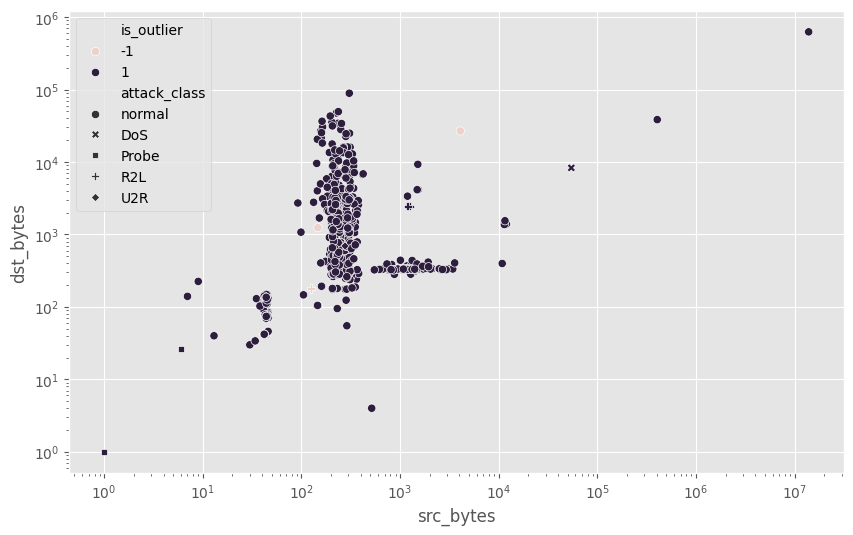

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train[::100], x = 'src_bytes', y = 'dst_bytes', hue='is_outlier', style='attack_class')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def apply_log_transform(df, cols):

    df_transformed = df.copy()   # Create copy safely

    for col in cols:
        df_transformed[col] = np.log1p(df_transformed[col])

        # Optional: plot transformed distribution
        plt.figure(figsize=(5,4))
        sns.histplot(df_transformed[col], bins=50, kde=True)
        plt.title(f"Log Transformed {col}")
        plt.show()

    return df_transformed

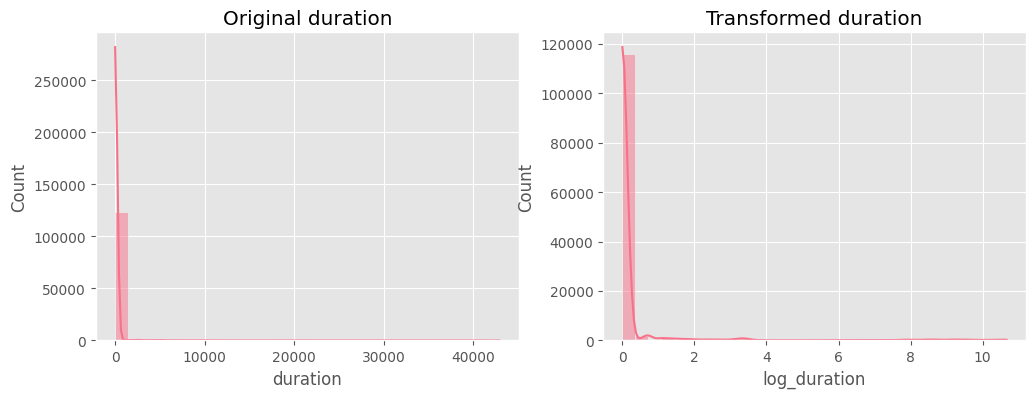

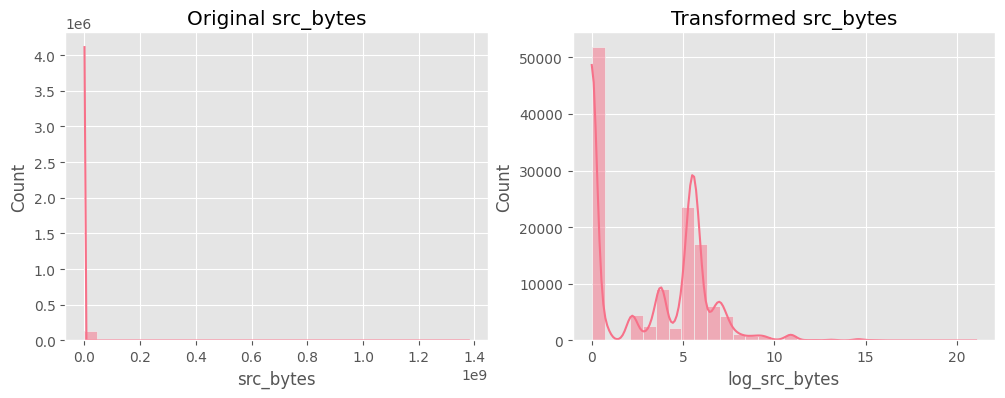

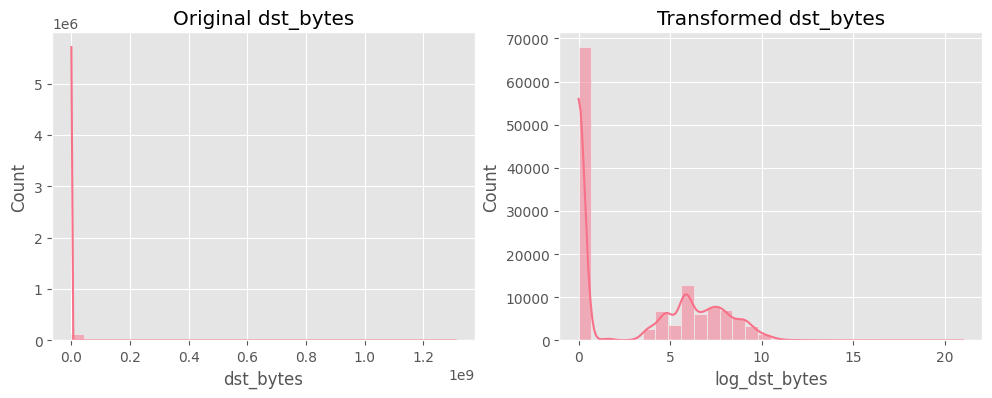

NameError: name 'df_transformed' is not defined

In [36]:
skewed_cols = ['duration','src_bytes','dst_bytes']

#Function for the Log1p transformation (log(x+1)) to  handle the zeros

def apply_log_transform(df,cols):
    df_transform = df.copy()
    for col in cols:
        #Creating a new column Name
        new_col = f"log_{col}"
        #applying the logarithimic operation

        df_transform[new_col] = np.log1p(df_transform[col])

        plt.figure(figsize = (12,4))
        plt.subplot(1,2,1)
        sns.histplot(df[col],bins = 30, kde=True)
        plt.title(f"Original {col}")

        plt.subplot(1,2,2)
        sns.histplot(df_transform[new_col],bins = 30, kde=True)
        plt.title(f"Transformed {col}")
        plt.show()
    return df_transformed

df_train = apply_log_transform(df_train,skewed_cols)
df_test = apply_log_transform(df_test,skewed_cols)


In [ ]:
import numpy as np
import pandas as pd

# Select three attributes
cols = ['duration', 'src_bytes', 'dst_bytes']

# Create a copy
log_df = train_df[cols].copy()

In [38]:
cols = ['duration', 'src_bytes', 'dst_bytes']

In [39]:
import numpy as np

log_df = train_df[cols].copy()

In [40]:
for col in cols:
    log_df[col] = np.log1p(log_df[col])

log_df.head()

,duration,src_bytes,dst_bytes
0,0.0,6.198479,0.000000
1,0.0,4.990433,0.000000
2,0.0,0.000000,0.000000
3,0.0,5.451038,9.006264
4,0.0,5.298317,6.042633


In [41]:
log_corr = log_df.corr()
print(log_corr)

           duration  src_bytes  dst_bytes
duration   1.000000   0.103887    0.08349
src_bytes  0.103887   1.000000    0.70235
dst_bytes  0.083490   0.702350    1.00000


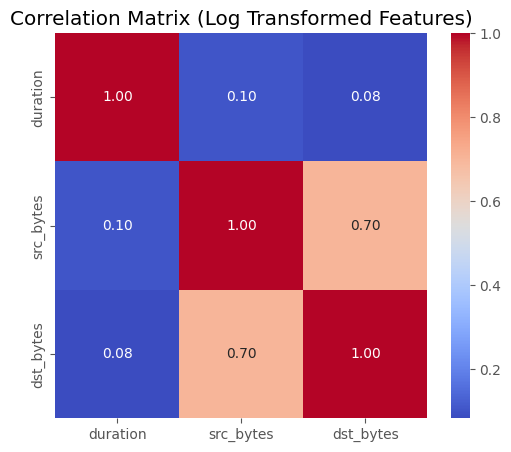

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.heatmap(log_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Log Transformed Features)")
plt.show()

In [43]:
from itertools import combinations

pairs = list(combinations(cols, 2))

for col1, col2 in pairs:
    corr_value = log_df[col1].corr(log_df[col2])
    print(f"Correlation between {col1} and {col2}: {corr_value:.4f}")

Correlation between duration and src_bytes: 0.1039
Correlation between duration and dst_bytes: 0.0835
Correlation between src_bytes and dst_bytes: 0.7024


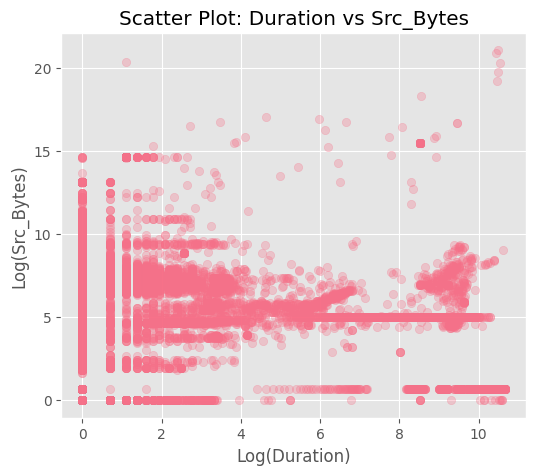

Correlation: 0.1038871135518743


In [44]:
plt.figure(figsize=(6,5))
plt.scatter(log_df['duration'], log_df['src_bytes'], alpha=0.3)
plt.xlabel('Log(Duration)')
plt.ylabel('Log(Src_Bytes)')
plt.title('Scatter Plot: Duration vs Src_Bytes')
plt.show()

print("Correlation:", log_df['duration'].corr(log_df['src_bytes']))

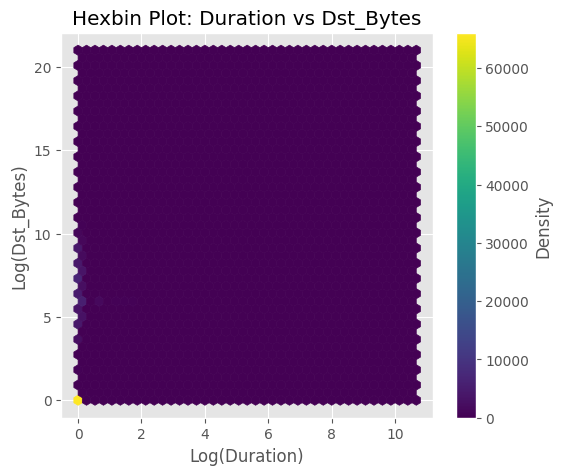

Correlation: 0.08349041551811529


In [45]:
plt.figure(figsize=(6,5))
plt.hexbin(log_df['duration'], log_df['dst_bytes'], gridsize=40)
plt.xlabel('Log(Duration)')
plt.ylabel('Log(Dst_Bytes)')
plt.title('Hexbin Plot: Duration vs Dst_Bytes')
plt.colorbar(label='Density')
plt.show()

print("Correlation:", log_df['duration'].corr(log_df['dst_bytes']))

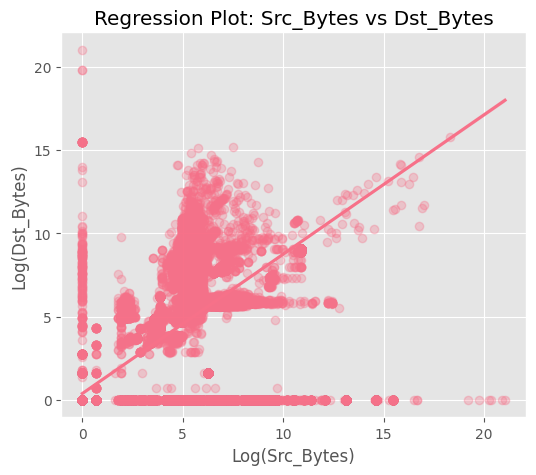

Correlation: 0.7023503920159634


In [46]:
import seaborn as sns

plt.figure(figsize=(6,5))
sns.regplot(x=log_df['src_bytes'], y=log_df['dst_bytes'], scatter_kws={'alpha':0.3})
plt.xlabel('Log(Src_Bytes)')
plt.ylabel('Log(Dst_Bytes)')
plt.title('Regression Plot: Src_Bytes vs Dst_Bytes')
plt.show()

print("Correlation:", log_df['src_bytes'].corr(log_df['dst_bytes']))

In [47]:
import numpy as np

# Select only numeric columns
numeric_cols = train_df.select_dtypes(include=np.number).columns

In [48]:
# Create copy
log_train_df = train_df.copy()

# Apply log(1 + x) transformation
for col in numeric_cols:
    log_train_df[col] = np.log1p(log_train_df[col])

In [49]:
log_train_df.to_csv("log_transformed_train.csv", index=False)

print("Log-transformed dataset saved successfully.")

Log-transformed dataset saved successfully.


In [50]:
from google.colab import files
files.download("log_transformed_train.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>